# library

In [1]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import *
from keras.models import *
from keras.activations import *
from keras.utils import np_utils

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt

/home/taeyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/taeyong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# data load & preprocessing

In [2]:
def get_MNIST():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # normalization
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # expanding dim
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    # one-hot encoding
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

In [3]:
def get_CIFAR10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # normalization
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # one-hot encoding
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

In [4]:
# x_train, y_train, x_test, y_test = get_MNIST()
x_train, y_train, x_test, y_test = get_CIFAR10()

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


# model

In [6]:
# model param
# MNIST
# input_height = 28
# input_width = 28
# c_dim = 1
# CIFAR-10
input_height = 32
input_width = 32
c_dim = 3
dim = 16
class_num = y_test.shape[1]

In [7]:
print(class_num)

10


In [8]:
def get_MNIST_model():
    # convolution layer
    inp = Input((input_height, input_width, c_dim))
    _ = Conv2D(dim, (5,5), strides=(2,2), padding='same')(inp)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
  
    _ = Conv2D(dim * 2, (5,5), strides=(2,2), padding='same')(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
  
    _ = Conv2D(dim * 4, (5,5), strides=(2,2), padding='same')(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
  
    _ = MaxPooling2D(pool_size=(2, 2))(_)
    _ = Flatten()(_)
  
    # fully connected layer
    _ = Dense(dim * 8)(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.3)(_)
  
    _ = Dense(dim * 4)(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
      
    _ = Dense(class_num)(_)
    out = Activation('softmax')(_)
    
    return Model(inp, out)

In [9]:
def get_CIFAR10_model():
    # convolution layer
    inp = Input((input_height, input_width, c_dim))
    _ = Conv2D(dim, (3,3), strides=(2,2), padding='same')(inp)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.2)(_)  

    _ = Conv2D(dim * 2, (3,3), strides=(2,2), padding='same')(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.2)(_)
  
    _ = Conv2D(dim * 4, (3,3), strides=(2,2), padding='same')(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.2)(_)

    _ = Conv2D(dim * 4, (3,3), strides=(2,2), padding='same')(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    
    _ = MaxPooling2D(pool_size=(2, 2))(_)                                  
    _ = Flatten()(_)
  
    # fully connected layer
    _ = Dense(dim * 4)(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.3)(_)
  
    _ = Dense(dim * 8)(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.3)(_)
                                                       
    _ = Dense(dim * 4)(_)
    _ = BatchNormalization()(_)
    _ = LeakyReLU(0.2)(_)
    _ = Dropout(0.3)(_)
      
    _ = Dense(class_num)(_)
    out = Activation('softmax')(_)
    
    return Model(inp, out)

In [10]:
# model = get_MNIST_model()
model = get_CIFAR10_model()

In [11]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 32)          128       
__________

# train

In [12]:
# train param
learning_rate = 0.001
decay = 1e-06
batch_size = 32
epochs = 30

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.adam(lr = learning_rate, decay = decay), metrics = ['accuracy'])

In [14]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 36s 716us/step - loss: 1.8631 - acc: 0.3131 - val_loss: 1.4837 - val_acc: 0.4538
Epoch 2/30
50000/50000 [==============================] - 35s 693us/step - loss: 1.5500 - acc: 0.4350 - val_loss: 1.4146 - val_acc: 0.4741
Epoch 3/30
50000/50000 [==============================] - 35s 691us/step - loss: 1.4427 - acc: 0.4797 - val_loss: 1.2956 - val_acc: 0.5279
Epoch 4/30
50000/50000 [==============================] - 35s 695us/step - loss: 1.3762 - acc: 0.5104 - val_loss: 1.2067 - val_acc: 0.5648
Epoch 5/30
50000/50000 [==============================] - 35s 696us/step - loss: 1.3115 - acc: 0.5354 - val_loss: 1.2696 - val_acc: 0.5511
Epoch 6/30
50000/50000 [==============================] - 35s 691us/step - loss: 1.2682 - acc: 0.5514 - val_loss: 1.1320 - val_acc: 0.6000
Epoch 7/30
50000/50000 [==============================] - 35s 693us/step - loss: 1.2416 - acc: 0.5618 - val_loss: 1.

In [15]:
model.save('model.h5')

# accuracy

In [16]:
scores = model.evaluate(x_test, y_test, verbose=0)

In [17]:
print(scores)

[0.894453050327301, 0.688]


# ROC curve

In [18]:
y_pred = np.array(model.predict(x_test))
y_true = np.array(y_test)

# from mpu.ml import *
# y_pred = np.array(one_hot2indices(y_pred))
# y_true = np.array(one_hot2indices(y_true))

In [19]:
print(y_pred.shape)
print(y_true.shape)

(10000, 10)
(10000, 10)


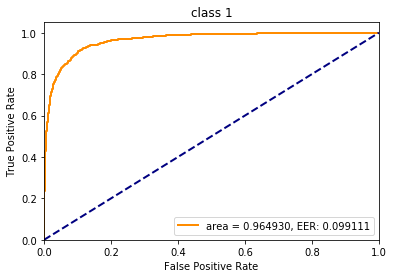

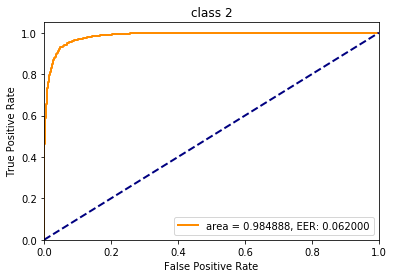

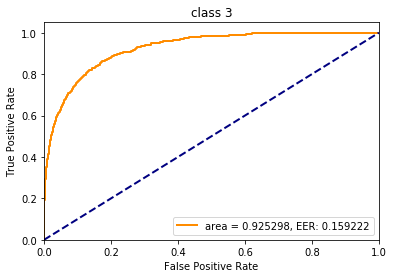

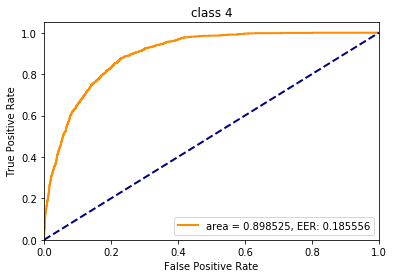

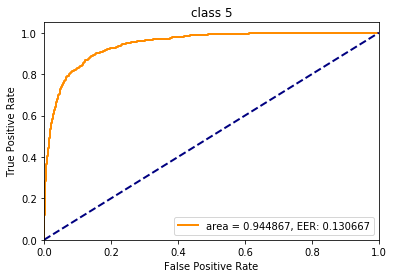

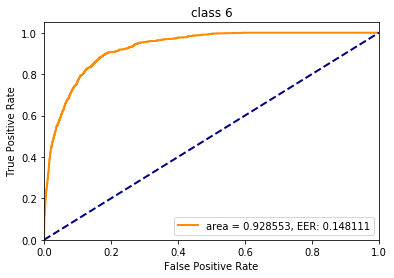

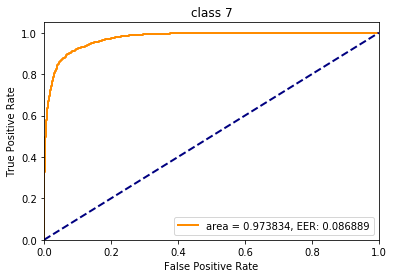

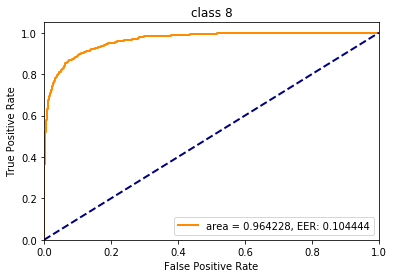

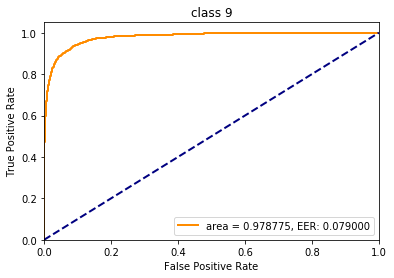

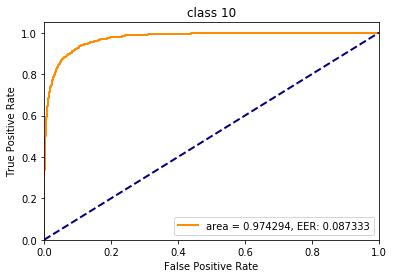

In [20]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    eer_threshold = fpr[i][np.argmin(np.abs(fpr[i] + tpr[i] - 1))]
    
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='area = %0.06f, EER: %0.06f' % (roc_auc[i], eer_threshold))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('class ' + str(i + 1))
    plt.legend(loc="lower right")
    plt.show()

In [21]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= class_num

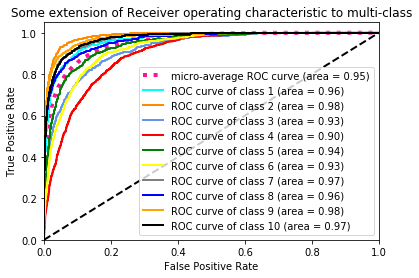

In [22]:
# Plot all ROC curves
plt.figure()
plt.plot(all_fpr, mean_tpr,
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(auc(all_fpr, mean_tpr)),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'gray', 'blue', 'orange', 'black'])
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()